# Importing Libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
from siuba.dply.forcats import fct_lump

### Setting Graph Style

In [2]:
sns.set_theme(style = 'darkgrid')

# Importing Data

In [3]:
df = pd.read_csv('netflix_titles.csv')
netflix = df.copy()
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


### Inspecting the Data

In [4]:
(netflix.isnull().sum()/len(netflix)) * 100

show_id          0.000000
type             0.000000
title            0.000000
director        30.679337
cast             9.220496
country          6.510851
date_added       0.128419
release_year     0.000000
rating           0.089893
duration         0.000000
listed_in        0.000000
description      0.000000
dtype: float64

# Preprocessing

In [5]:
# filling missing values for each variables
netflix['director'] = netflix['director'].fillna(value = 'No Director')
netflix['cast'] = netflix['cast'].fillna(value = 'No Cast')
netflix['country'] = netflix['country'].fillna(value = 'United States')
netflix['date_added'] = netflix['date_added'].fillna(value = datetime.datetime(2020, 1,1))
netflix['rating'] = netflix['rating'].fillna(value = 'Other')

# lump together least/most common factor levels into "other"
netflix['rating'] = fct_lump(netflix['rating'], n = 5)

# getting the months from the dates
netflix['month'] = pd.to_datetime(netflix['date_added']).dt.month

In [6]:
(netflix.isnull().sum()/len(netflix)) * 100

show_id         0.0
type            0.0
title           0.0
director        0.0
cast            0.0
country         0.0
date_added      0.0
release_year    0.0
rating          0.0
duration        0.0
listed_in       0.0
description     0.0
month           0.0
dtype: float64

# Creating Useful Functions for Efficiency!

In [7]:
def column_list_tokenizer_count(df, subset_cols, secondary_col):
    '''
    df: Insert the dataframe that you're working with (only works for the columns you are trying to tokenize within a list).

    subset_cols: Insert a column that you want to subset to remove any missing values within that column. Keep in mind this will       also be the columns that will be tokenized once you insert into the function.

    secondary_col: Insert an additional column if you would like to filter a specific value from the new counted dataset. If not,      just input 'None'.
    
    (Headsup!: Once you use the function do not worry about the name of the columns it will give you the same output if you were       to use it normally, you can always rename it by using the '.rename()' method. Always use the .columns method! There could be a     pesky whitespace that could output an error when renaming the columns!)
    '''
    # Creating an empty list
    token_list = []

    # Removing any missing values just in case if they are any within the dataset. As well reseting the index.
    clean_df = df.dropna(subset = [subset_cols])
    clean_df.reset_index(inplace = True)
    
    # This for loop would go to every single row and split the string values into a list essentially tokenizing them.
    if secondary_col == None:
        for i, element in clean_df.iterrows():
            for token in str(element[subset_cols]).strip(' ').split(','):
                token_list.append([token.strip()])

    # Returns a dataframe based from the appended list and counting each unique value from the inserted 'subset_cols' variable.
        token_data = pd.DataFrame(data = token_list, columns = [token])
        return token_data
    else:
        for i, element in clean_df.iterrows():
            secondary_cols = element[secondary_col]
            for token in str(element[subset_cols]).strip(' ').split(','):
                token_list.append([secondary_cols, token.strip()])

        token_data = pd.DataFrame(data = token_list, columns = [secondary_cols, token])
        return token_data.value_counts().to_frame().rename(columns = {0: 'count'}).reset_index(level = [0, 1])

In [8]:
def plot_bar(x_var, y_var, df, num_colors, title_name, xlabel_name, ylabel_name, hue_col):
    if hue_col == None:
        plt.figure(figsize = (10,6))
        sns.barplot(x = x_var, y = y_var, data = df, ci = False,
                    palette = sns.dark_palette(color = '#b60c26', n_colors = num_colors, reverse = True, input = 'hsl'))
        plt.title(title_name, fontdict = {'fontsize': 16, 'fontweight': 'bold'})
        plt.xlabel(xlabel_name)
        plt.ylabel(ylabel_name)
        plt.show()
    else:
        plt.figure(figsize = (10,6))
        sns.barplot(x = x_var, y = y_var, data = df, ci = False, hue = hue_col,
                    palette = sns.dark_palette(color = '#b60c26', n_colors = num_colors, reverse = True, input = 'hsl'))
        plt.title(title_name, fontdict = {'fontsize': 16, 'fontweight': 'bold'})
        plt.xlabel(xlabel_name)
        plt.ylabel(ylabel_name)
        plt.show()

# Genres Distribution between Movies and TV Shows

In [9]:
genre_data = (column_list_tokenizer_count(df = netflix, subset_cols = 'listed_in', secondary_col = 'type')
             .rename(columns = {'Movie': 'type', ' Music & Musicals': 'genre'}))

In [10]:
top_genre_movies = genre_data[genre_data['type'] == 'Movie'].nlargest(n = 10, columns= 'count')
top_genre_movies

,type,genre,count
0,Movie,International Movies,2437
1,Movie,Dramas,2106
2,Movie,Comedies,1471
4,Movie,Documentaries,786
5,Movie,Action & Adventure,721
7,Movie,Independent Movies,673
8,Movie,Children & Family Movies,532
9,Movie,Romantic Movies,531
11,Movie,Thrillers,491
16,Movie,Stand-Up Comedy,329


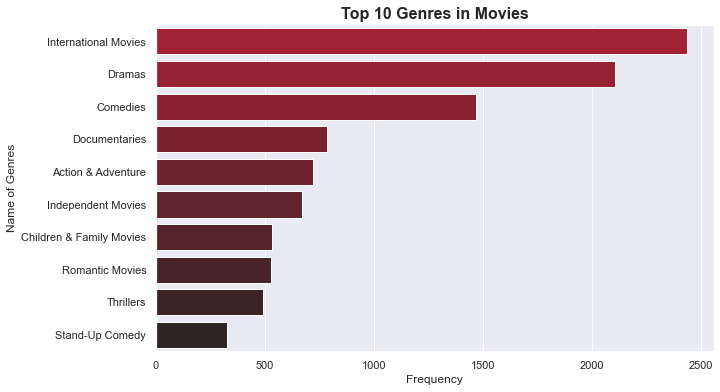

In [11]:
plot_bar(x_var = 'count',
         y_var = 'genre',
         df = top_genre_movies, 
         num_colors = 10, 
         title_name = 'Top 10 Genres in Movies', 
         xlabel_name = 'Frequency', 
         ylabel_name = 'Name of Genres',
         hue_col= None)

In [12]:
top_genre_shows = genre_data[genre_data['type'] == 'TV Show'].nlargest(n = 10, columns= 'count')
top_genre_shows

,type,genre,count
3,TV Show,International TV Shows,1199
6,TV Show,TV Dramas,704
10,TV Show,TV Comedies,525
12,TV Show,Crime TV Shows,427
13,TV Show,Kids' TV,414
14,TV Show,Docuseries,353
15,TV Show,Romantic TV Shows,333
19,TV Show,British TV Shows,232
20,TV Show,Reality TV,222
23,TV Show,Korean TV Shows,150


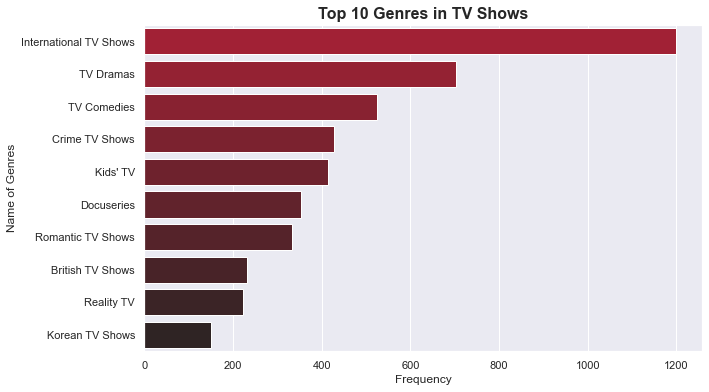

In [13]:
plot_bar(x_var = 'count',
         y_var = 'genre',
         df = top_genre_shows, 
         num_colors = 10, 
         title_name = 'Top 10 Genres in TV Shows', 
         xlabel_name = 'Frequency', 
         ylabel_name = 'Name of Genres', 
         hue_col = None)

# Content Type Distibution in the World

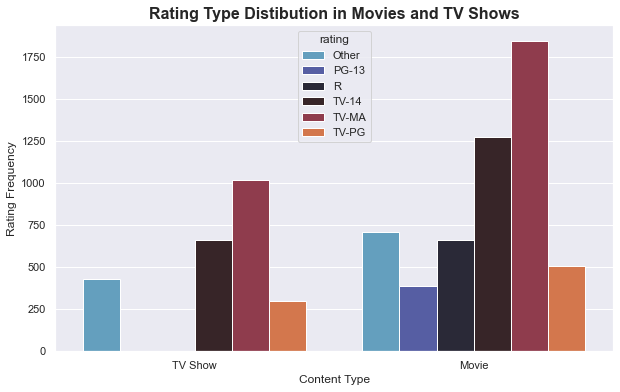

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(x = 'type', hue = 'rating', data = netflix, palette = sns.color_palette("icefire"))
plt.title('Rating Type Distibution in Movies and TV Shows', fontdict = {'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Content Type')
plt.ylabel('Rating Frequency')
plt.show()

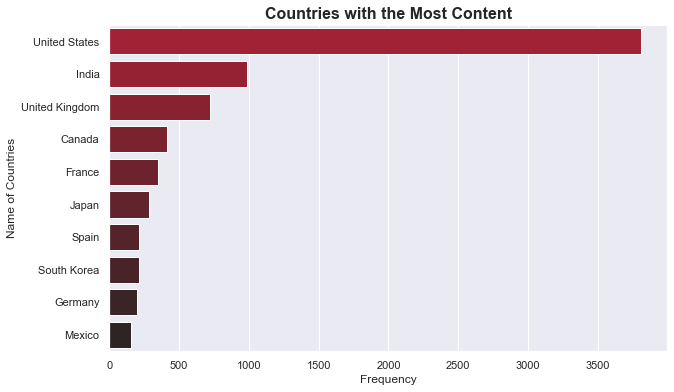

In [15]:
top_10_countries = (column_list_tokenizer_count(df=netflix, subset_cols= 'country', secondary_col=None)
                   .value_counts()
                   .to_frame()
                   .reset_index()
                   .rename(columns = {' United States': 'country', 0:'count'})
                   .nlargest(n = 10, columns = 'count'))

plot_bar(x_var = 'count',
         y_var='country',
         df = top_10_countries, 
         xlabel_name= 'Frequency', 
         ylabel_name='Name of Countries', 
         title_name = 'Countries with the Most Content', 
         num_colors = 10, 
         hue_col = None)

In [16]:
country_data = (column_list_tokenizer_count(df = netflix, subset_cols = 'country',secondary_col = 'type')
                .rename(columns = {'Movie': 'type', ' United States': 'country'}))
top_countries_content = country_data[country_data['country'].isin(top_10_countries['country'])]
top_countries_content.head()

,type,country,count
0,Movie,United States,2661
1,TV Show,United States,1143
2,Movie,India,915
3,Movie,United Kingdom,467
4,Movie,Canada,286


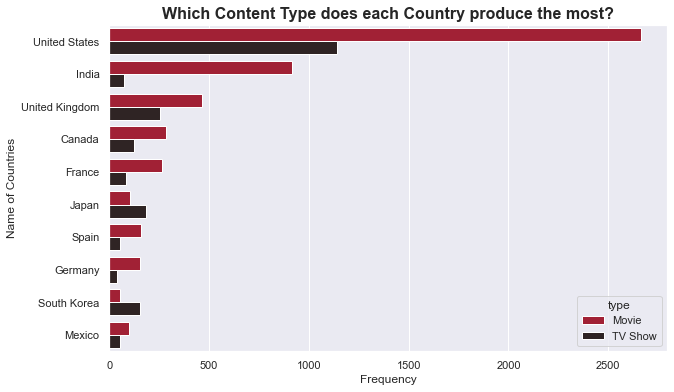

In [17]:
plot_bar(x_var = 'count', 
         y_var = 'country', 
         df = top_countries_content,
         num_colors= 2, 
         xlabel_name = 'Frequency', 
         ylabel_name = 'Name of Countries', 
         title_name = 'Which Content Type does each Country produce the most?', 
         hue_col = 'type')

# The Growth between Movies and TV Shows over the years

In [18]:
years_count_type = (netflix[netflix['release_year'] < 2021]
                   .groupby(by = ['type', 'release_year'], as_index = False)['show_id']
                   .count())
years_count_type.rename(columns = {'show_id': 'count'}, inplace = True)
years_count_type.head()

,type,release_year,count
0,Movie,1942,2
1,Movie,1943,3
2,Movie,1944,3
3,Movie,1945,3
4,Movie,1946,1


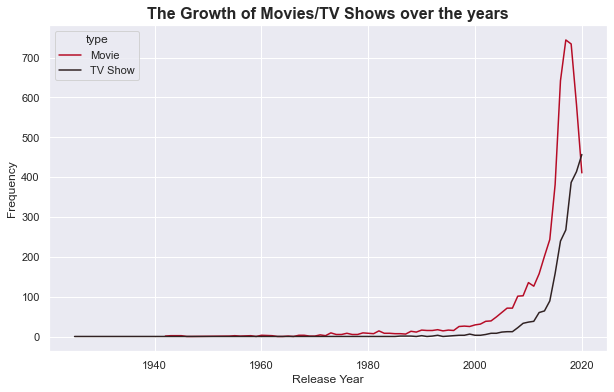

In [19]:
plt.figure(figsize = (10, 6))
sns.lineplot(x = 'release_year', y = 'count', hue = 'type', data = years_count_type, 
             palette = sns.dark_palette(color = '#b60c26', n_colors = 2, reverse = True, input = 'hsl'))
plt.title('The Growth of Movies/TV Shows over the years', fontdict = {'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Release Year')
plt.ylabel('Frequency')
plt.show()

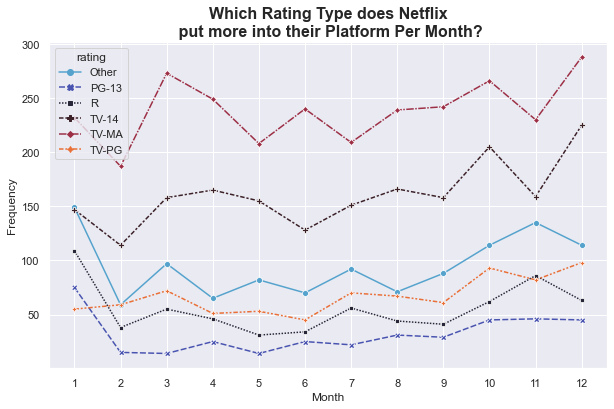

In [20]:
net_rating = (netflix
             .groupby(by = ['month', 'rating'])['month']
             .count()
             .to_frame()
             .rename(columns = {'month':'count'})
             .reset_index())

plt.figure(figsize = (10,6))
sns.lineplot(x = 'month', 
             y = 'count', 
             data = net_rating,
             hue ='rating', 
             style = 'rating', 
             markers= True,
             palette = sns.color_palette("icefire"))

plt.title('Which Rating Type does Netflix\n put more into their Platform Per Month?', 
           fontdict = {'fontsize': 16, 'fontweight': 'bold'})
plt.xticks(ticks = net_rating['month'].unique())
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

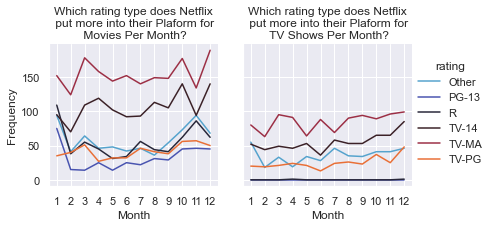

In [21]:
net_type = (netflix
            .groupby(by = ['month', 'rating', 'type'])['month']
            .count().to_frame()
            .rename(columns = {'month':'count'})
            .reset_index())

g = sns.FacetGrid(net_type, col = 'type', hue = 'rating', palette = sns.color_palette('icefire'))
g.map(sns.lineplot, 'month', 'count')
g.set_titles(col_template = 'Which rating type does Netflix\n put more into their Plaform for\n {col_name}s Per Month?')
g.set_axis_labels('Month', 'Frequency')
g.set(xticks = net_type['month'].unique())
g.fig.subplots_adjust(wspace=.15, hspace=.25)
g.add_legend()

# Director Analysis for Movies and TV Shows

In [22]:
director_data = (column_list_tokenizer_count(df = netflix, subset_cols = 'director', secondary_col = 'type')
                .rename(columns = {'Movie': 'type', 'Sam Dunn': 'director'}))
director_data.head()

,type,director,count
0,TV Show,No Director,2226
1,Movie,No Director,163
2,Movie,Jan Suter,21
3,Movie,Raúl Campos,19
4,Movie,Marcus Raboy,15


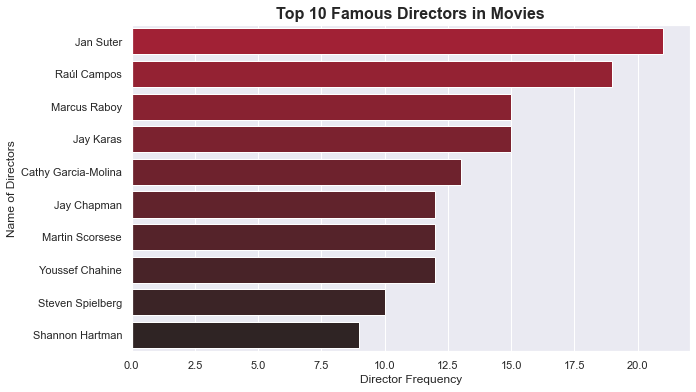

In [23]:
top_director_movies = (director_data[(director_data['type'] == 'Movie') & (director_data['director'] != 'No Director')]
                      .nlargest(n = 10, columns= 'count'))
                      
plot_bar(x_var = 'count', y_var = 'director', hue_col = None,
         df = top_director_movies, xlabel_name = 'Director Frequency', ylabel_name = 'Name of Directors', num_colors = 10,
         title_name = 'Top 10 Famous Directors in Movies')

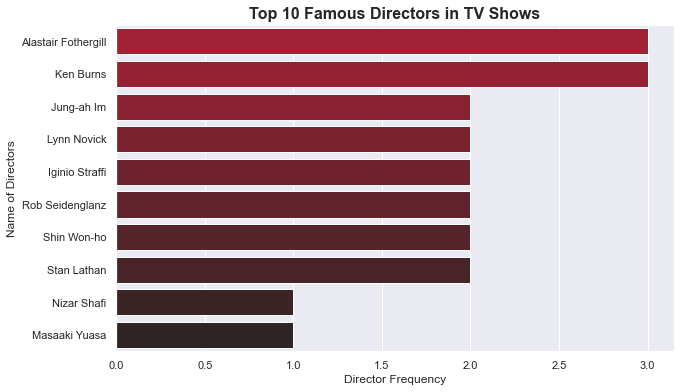

In [24]:
top_director_shows = (director_data[(director_data['type'] == 'TV Show') & (director_data['director'] != 'No Director')]
                      .nlargest(n = 10, columns= 'count'))
                      
plot_bar(x_var = 'count', y_var = 'director', hue_col = None,
         df = top_director_shows, xlabel_name = 'Director Frequency', ylabel_name = 'Name of Directors', num_colors = 10,
         title_name = 'Top 10 Famous Directors in TV Shows')

# Actor Analysis for Movies and TV Shows

In [25]:
actor_data = (column_list_tokenizer_count(df = netflix, subset_cols = 'cast', secondary_col = 'type')
             .rename(columns = {'Movie': 'type', 'No Cast': 'cast'}))
actor_data.head()

,type,cast,count
0,Movie,No Cast,426
1,TV Show,No Cast,292
2,Movie,Anupam Kher,41
3,Movie,Shah Rukh Khan,35
4,Movie,Naseeruddin Shah,30


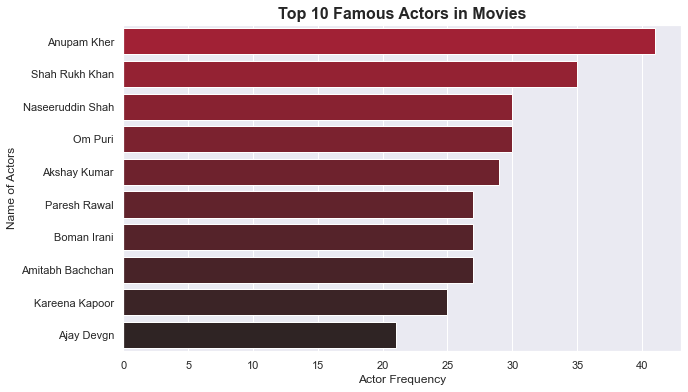

In [26]:
top_actor_movies = (actor_data[(actor_data['type'] == 'Movie') & (actor_data['cast'] != 'No Cast')]
                    .nlargest(n = 10, columns= 'count'))
                      
plot_bar(x_var = 'count', y_var = 'cast', hue_col = None,
         df = top_actor_movies, xlabel_name = 'Actor Frequency', ylabel_name = 'Name of Actors', num_colors = 10,
         title_name = 'Top 10 Famous Actors in Movies')

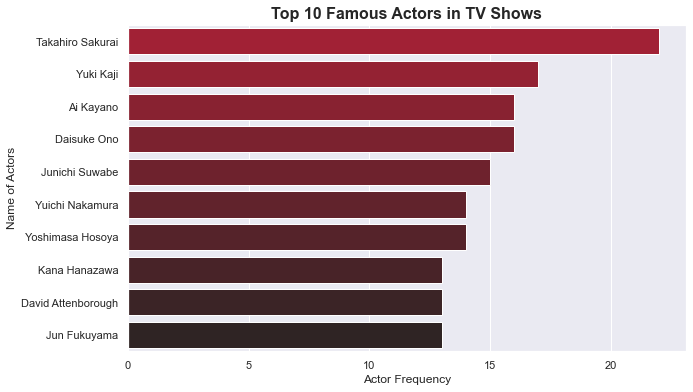

In [27]:
top_actor_shows = (actor_data[(actor_data['type'] == 'TV Show') & (actor_data['cast'] != 'No Cast')]
                    .nlargest(n = 10, columns= 'count'))
                      
plot_bar(x_var = 'count', y_var = 'cast', hue_col = None,
         df = top_actor_shows, xlabel_name = 'Actor Frequency', ylabel_name = 'Name of Actors', num_colors = 10,
         title_name = 'Top 10 Famous Actors in TV Shows')